# light training script


## imports

In [23]:
import os, re, math, random
from pathlib import Path
from typing import List, Tuple
import numpy as np
import pandas as pd
import pydicom
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as T
import warnings
from tqdm.notebook import tqdm
from torch.utils.data import Subset


## ---------------- Config ----------------

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CSV_PATH = r"C:\Users\tomer.erez\Desktop\code_projects\normal_near_normal\stanford_data\labels.csv"
BATCH_DIR = Path(r"C:\Users\tomer.erez\Desktop\code_projects\normal_near_normal\stanford_data\ctsinogram\head_ct_dataset_anon\batch_1")
D_TARGET = 40            # fixed depth
CENTER, WIDTH = 40, 80   # brain window
BATCH_SIZE = 2
SEED = 42
torch.manual_seed(SEED)


## -------------- helpers -----------------

In [25]:
def find_dicom_folder(series_root: Path) -> Path or None:
    """Find the folder under series_root that contains DICOMs.
       Priority:
         1) folder named 'reconstructed image' or 'reconstructed_image' (case-insensitive)
         2) any subfolder whose name contains 'reconstruct'
         3) series_root itself if it contains .dcm files
       Returns Path or None if nothing found.
    """
    if not series_root.exists():
        return None
    # candidate exact names
    for name in ("reconstructed image", "reconstructed_image"):
        cand = series_root / name
        if cand.is_dir() and any(p.suffix.lower() == ".dcm" for p in cand.iterdir()):
            return cand
    # any subfolder containing 'reconstruct' in name
    for p in series_root.iterdir():
        if p.is_dir() and "reconstruct" in p.name.lower() and any(q.suffix.lower() == ".dcm" for q in p.iterdir()):
            return p
    # fallback: series_root itself if it contains DICOMs
    if any(p.suffix.lower() == ".dcm" for p in series_root.iterdir()):
        return series_root
    return None

def read_sorted_dcm_paths(folder: Path):
    """Return sorted list of dcm file paths (strings)."""
    files = [str(p) for p in folder.iterdir() if p.suffix.lower() == ".dcm"]
    if not files:
        return []
    def key_fn(p):
        try:
            ds = pydicom.dcmread(p, stop_before_pixels=True)
            if hasattr(ds, "ImagePositionPatient"):
                return float(ds.ImagePositionPatient[2])
            if hasattr(ds, "SliceLocation"):
                return float(ds.SliceLocation)
            if hasattr(ds, "InstanceNumber"):
                return int(ds.InstanceNumber)
        except Exception:
            pass
        m = re.search(r"(\d+)", os.path.basename(p))
        return int(m.group(1)) if m else 0
    files.sort(key=key_fn)
    return files


In [26]:
def ds_to_windowed_array(ds, center=CENTER, width=WIDTH):
    arr = ds.pixel_array.astype(np.int16)
    slope = float(getattr(ds, "RescaleSlope", 1.0))
    intercept = float(getattr(ds, "RescaleIntercept", 0.0))
    hu = arr * slope + intercept
    lo, hi = center - width/2.0, center + width/2.0
    clipped = np.clip(hu, lo, hi)
    norm = (clipped - lo) / (hi - lo + 1e-6)   # float32 in [0,1]
    return norm.astype(np.float32)


## -------------- Dataset ------------------

In [27]:
all_series_dirs = sorted([p for p in BATCH_DIR.iterdir() if p.is_dir() and re.match(r"series_\d+", p.name)])
print(f"Found {len(all_series_dirs)} series directories under {BATCH_DIR}")

# Build dict: series_id_string -> dicom_folder_path (or None)
series_to_folder = {}
for sdir in all_series_dirs:
    dicom_folder = find_dicom_folder(sdir)
    if dicom_folder is None:
        # keep None to allow reporting later
        series_to_folder[sdir.name] = None
    else:
        series_to_folder[sdir.name] = str(dicom_folder)

# ---------------- Load CSV and filter to existing series ----------------
df = pd.read_csv(CSV_PATH, sep=None, engine="python")
# normalize column name for series id
if "patient_id" not in df.columns:
    for alt in ("path","patient","series"):
        if alt in df.columns:
            df = df.rename(columns={alt:"patient_id"})
            break
assert "patient_id" in df.columns, "CSV missing patient_id column"

# Filter CSV rows to those present on disk and where dicom folder exists
df["series_folder"] = df["patient_id"].astype(str).map(series_to_folder)
df_available = df[df["series_folder"].notnull()].reset_index(drop=True)
missing = df[df["series_folder"].isnull()]
print(f"CSV rows: {len(df)}, available on disk: {len(df_available)}, missing: {len(missing)}")
if len(missing):
    warnings.warn(f"{len(missing)} entries in CSV have no corresponding dicom folder on disk (first 10 shown). "
                  f"Examples: {missing['patient_id'].tolist()[:10]}")


Found 1112 series directories under C:\Users\tomer.erez\Desktop\code_projects\normal_near_normal\stanford_data\ctsinogram\head_ct_dataset_anon\batch_1
CSV rows: 9779, available on disk: 1112, missing: 8667


C:\Users\tomer.erez\AppData\Local\Temp\ipykernel_21984\3907705180.py:30: UserWarning: 8667 entries in CSV have no corresponding dicom folder on disk (first 10 shown). Examples: ['series_2', 'series_3', 'series_4', 'series_5', 'series_6', 'series_7', 'series_8', 'series_9', 'series_20', 'series_21']
  warnings.warn(f"{len(missing)} entries in CSV have no corresponding dicom folder on disk (first 10 shown). "


In [28]:
class HeadCTPadDataset(Dataset):
    def __init__(self, df_filtered: pd.DataFrame, d_target:int = D_TARGET, center=CENTER, width=WIDTH):
        self.df = df_filtered.reset_index(drop=True)
        self.d_target = int(d_target)
        self.center = center
        self.width = width

    def __len__(self):
        return len(self.df)

    @staticmethod
    def _label_to_index(label_val):
        # label like "1,0" -> index 0, or if integer return that
        if isinstance(label_val, str) and "," in label_val:
            parts = [int(x) for x in label_val.split(",")]
            return int(np.argmax(parts))
        try:
            return int(label_val)
        except Exception:
            raise ValueError("Can't parse label: " + str(label_val))

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        series_id = str(row["patient_id"])
        label_idx = self._label_to_index(row.iloc[1])   # assume second column holds label
        folder = Path(row["series_folder"])
        dcm_paths = read_sorted_dcm_paths(folder)
        if len(dcm_paths) == 0:
            raise RuntimeError(f"No DICOMs found for {series_id} in {folder}")

        # read slices (windowed float in [0,1])
        slices = []
        for p in dcm_paths:
            ds = pydicom.dcmread(p)
            arr = ds_to_windowed_array(ds, center=self.center, width=self.width)
            slices.append(arr)
        vol = np.stack(slices, axis=0)  # (D_orig, H, W), float32 in [0,1]

        # pad or truncate to D_TARGET (pad at end)
        d_orig, h, w = vol.shape
        if d_orig < self.d_target:
            pad = np.zeros((self.d_target - d_orig, h, w), dtype=np.float32)
            vol = np.concatenate([vol, pad], axis=0)
        elif d_orig > self.d_target:
            vol = vol[:self.d_target, :, :]

        # convert to torch tensor shape (1, D, H, W)
        vol_t = torch.from_numpy(vol).unsqueeze(0)  # float32
        label_t = torch.tensor(label_idx, dtype=torch.long)
        return vol_t, label_t


## -------------- Small model ----------------

In [29]:
class Tiny3DCNN(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv3d(1, 8, 3, padding=1), nn.ReLU(), nn.MaxPool3d(2),
            nn.Conv3d(8, 16, 3, padding=1), nn.ReLU(), nn.MaxPool3d(2),
            nn.Conv3d(16, 32, 3, padding=1), nn.ReLU(), nn.AdaptiveAvgPool3d(1)
        )
        self.fc = nn.Linear(32, num_classes)

    def forward(self, x):
        x = self.net(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)



# -------------- training utilities ------------

In [30]:
from tqdm.auto import tqdm  # picks notebook widget if available, otherwise console

def accuracy(preds, targets):
    """Return number of correct predictions (int)."""
    preds_cls = preds.argmax(dim=1)
    return int((preds_cls == targets).sum().item())

def validate(model, loader, loss_fn, device=DEVICE):
    model.eval()
    running_loss = 0.0
    correct = 0
    n = 0
    with torch.no_grad():
        for xb, yb in tqdm(loader, desc="val", leave=False):
            xb = xb.to(device)
            yb = yb.to(device)
            logits = model(xb)
            loss = loss_fn(logits, yb)

            bs = xb.size(0)
            running_loss += float(loss.item()) * bs
            correct += int((logits.argmax(dim=1) == yb).sum().item())
            n += bs

    avg_loss = running_loss / n if n > 0 else 0.0
    acc = correct / n if n > 0 else 0.0
    return avg_loss, acc


### ---------------- Prepare data and model ----------------

In [ ]:
BATCH_SIZE = 8

dataset = HeadCTPadDataset(df_available, d_target=D_TARGET, center=CENTER, width=WIDTH)
print(f"Dataset length (available samples): {len(dataset)}")

if len(dataset) == 0:
    raise RuntimeError("No available samples found. Check paths and CSV.")

# train/val split
val_n = max(1, int(len(dataset) * 0.2))
train_n = len(dataset) - val_n
train_ds, val_ds = random_split(dataset, [train_n, val_n], generator=torch.Generator().manual_seed(SEED))

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0,pin_memory=False)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0,pin_memory=False)


Dataset length (available samples): 1112


In [32]:
sample, label = dataset[0]   # index 0 - loads one series
print("sample shape:", sample.shape, "label:", label)

sample shape: torch.Size([1, 40, 512, 512]) label: tensor(1)


In [33]:
# quick smoke-test: fetch one batch
xb, yb = next(iter(train_loader))
print("Batch X shape:", xb.shape, "Batch y shape:", yb.shape)
# xb shape -> (B, 1, D_TARGET, H, W)

Batch X shape: torch.Size([8, 1, 40, 512, 512]) Batch y shape: torch.Size([8])


In [34]:
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)

model = Tiny3DCNN(num_classes=2).to(DEVICE)
criterion = torch.nn.CrossEntropyLoss()   # expects (B, C) logits and (B,) long targets
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

## --------------- Quick debug: show a batch ---------------


Batch shape: torch.Size([8, 1, 40, 512, 512])  labels: tensor([1, 1, 1, 1, 1, 1, 1, 0])


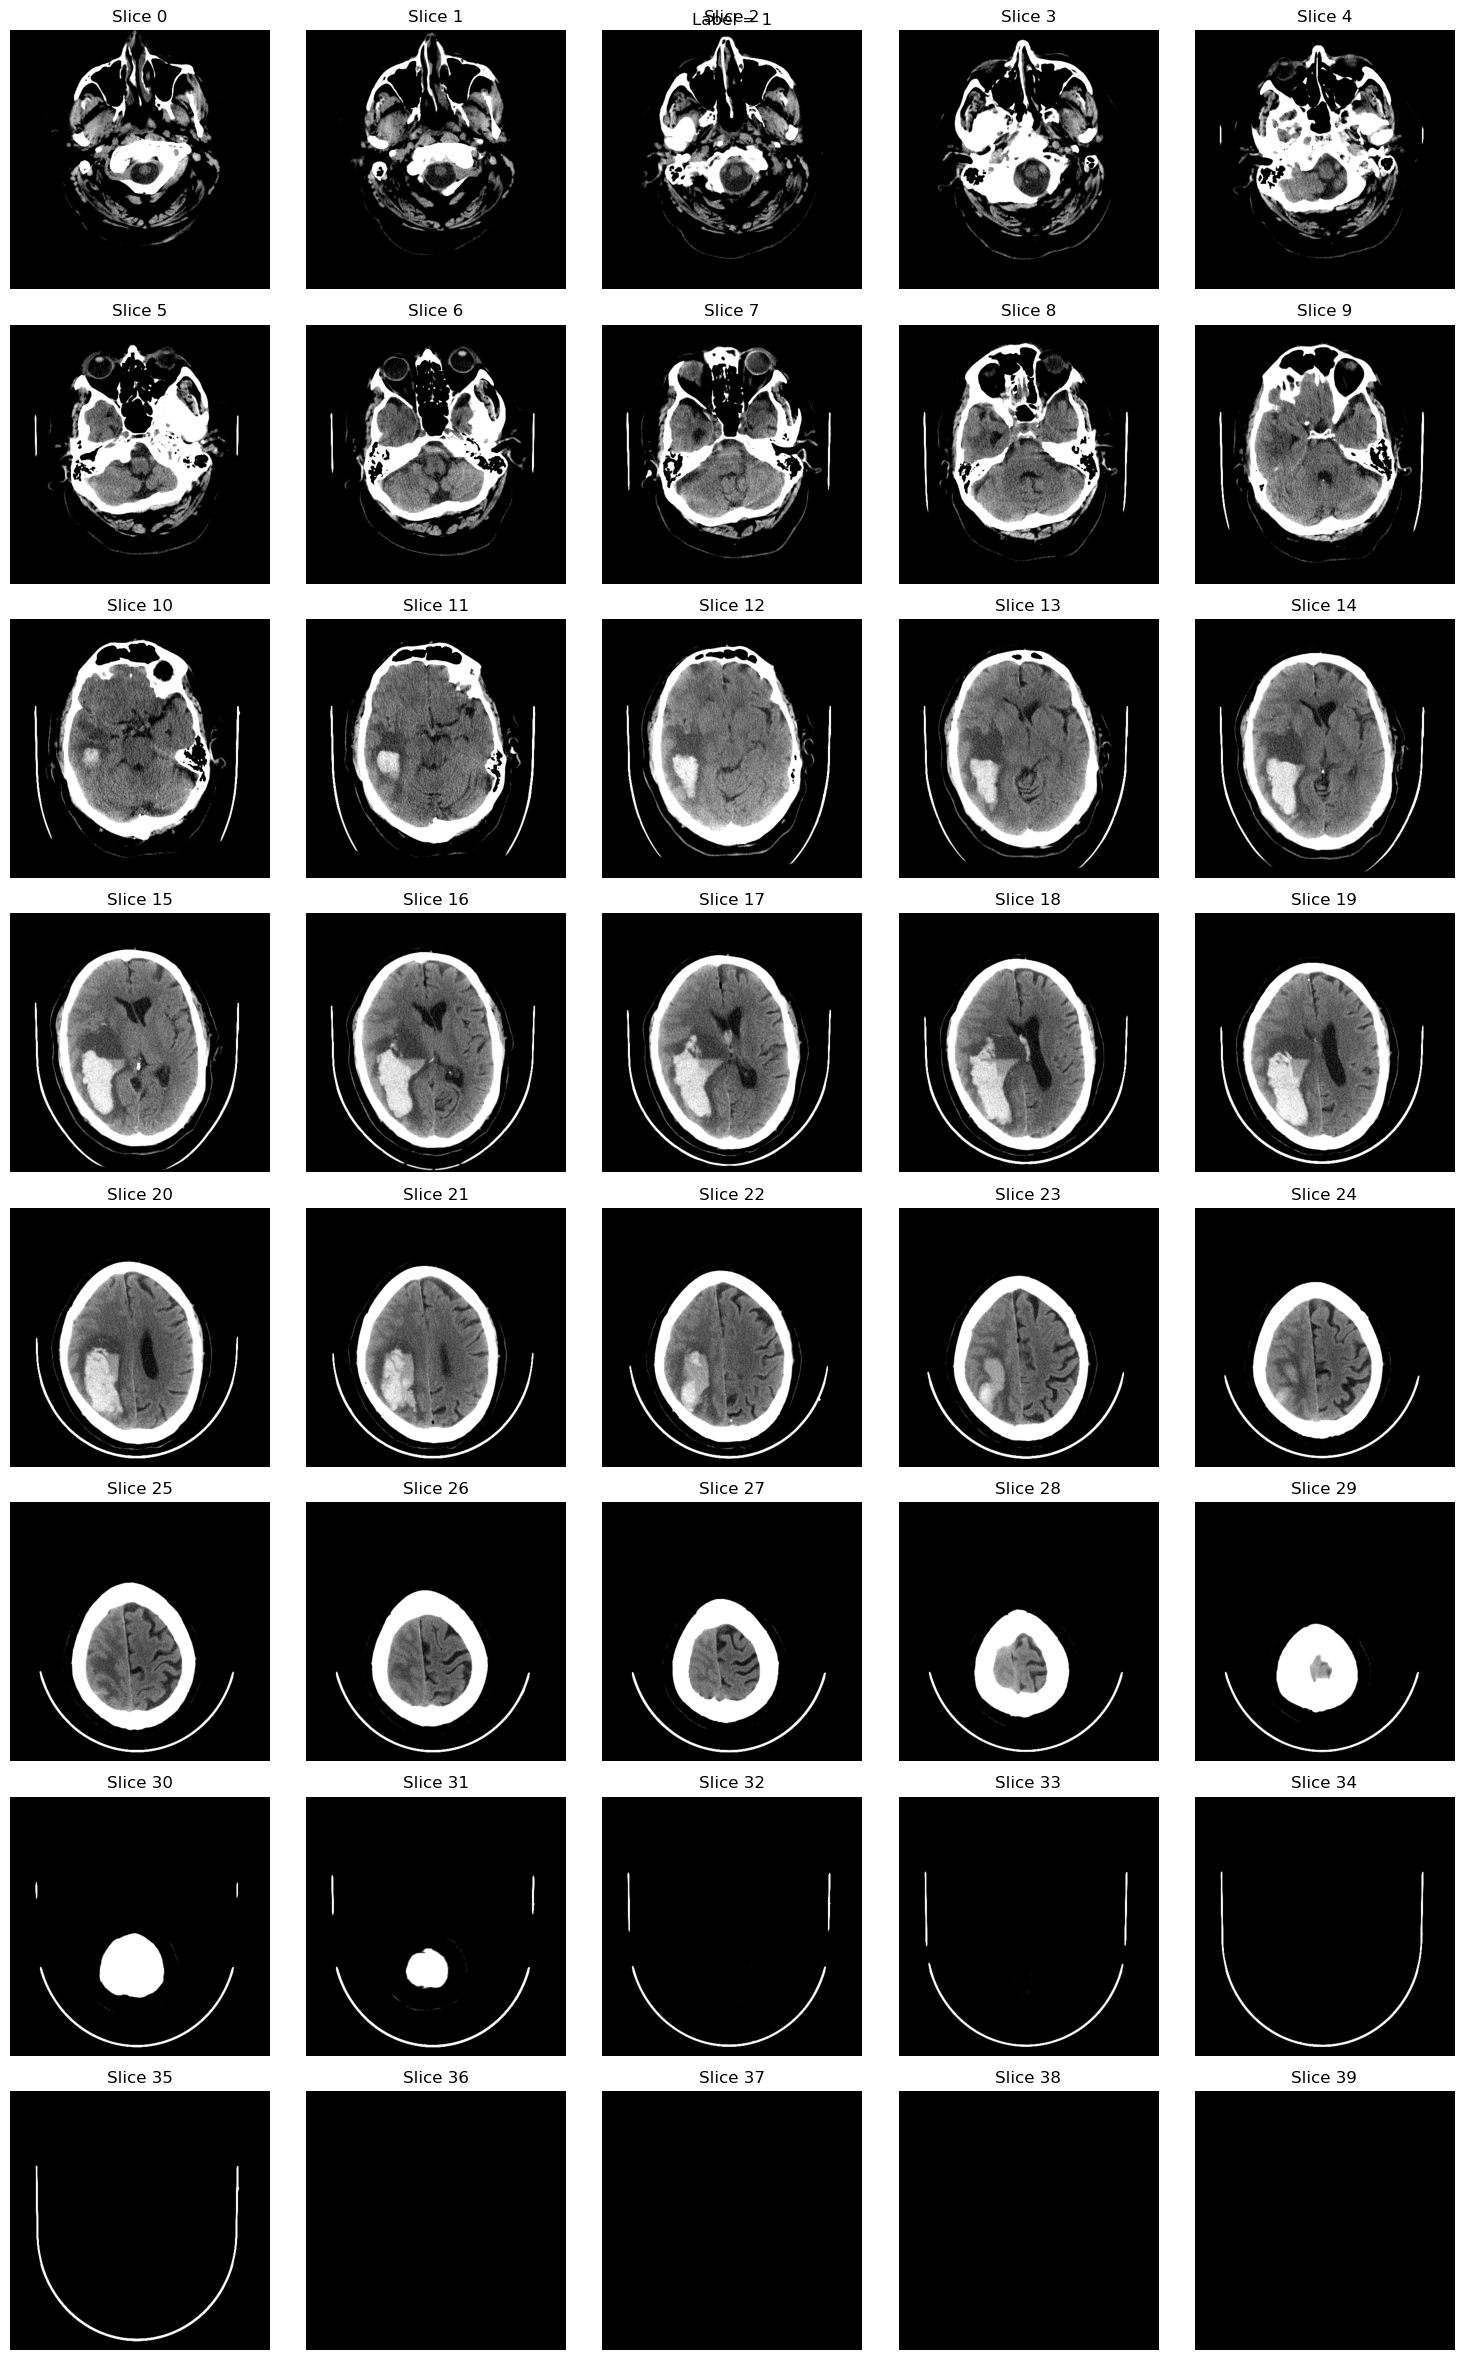

In [35]:
xb, yb = next(iter(train_loader))
print("Batch shape:", xb.shape, " labels:", yb)
volume = xb[0][0].numpy()   # shape (40, 512, 512)
label = int(yb[0])

n_slices = volume.shape[0]  # 40
n_cols = 5
n_rows = int(np.ceil(n_slices / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*3, n_rows*3))

for i in range(n_slices):
    row, col = divmod(i, n_cols)
    ax = axes[row, col]
    ax.imshow(volume[i], cmap="gray")
    ax.set_title(f"Slice {i}")
    ax.axis("off")

# hide empty plots (if any)
for j in range(n_slices, n_rows*n_cols):
    row, col = divmod(j, n_cols)
    axes[row, col].axis("off")

plt.suptitle(f"Label = {label}")
plt.tight_layout()
plt.show()


## ---------------- Training loop ----------------


In [ ]:

EPOCHS = 5
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0

    for i, (X, y) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")):
        X, y = X.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        out = model(X)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X.size(0)   # weight by batch size

    avg_train_loss = train_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}, Train Loss={avg_train_loss:.4f}")

    # optional: validation at end of each epoch
    val_loss, val_acc = validate(model, val_loader, criterion, device=DEVICE)
    print(f"  Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")


Epoch 1/5:   0%|          | 0/112 [00:00<?, ?it/s]